In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import shap
pd.set_option('display.max_columns', None)

In [3]:
def rmsle(y_true, y_pred):
    """
    Computes the Root Mean Squared Logarithmic Error 
    
    Args:
        y_true (np.array): n-dimensional vector of ground-truth values 
        y_pred (np.array): n-dimensional vecotr of predicted values 
    
    Returns:
        A scalar float with the rmsle value 
    
    Note: You can alternatively use sklearn and just do: 
        `sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5`
    """
    assert (y_true >= 0).all(), 'Received negative y_true values'
    assert (y_pred >= 0).all(), 'Received negative y_pred values'
    assert y_true.shape == y_pred.shape, 'y_true and y_pred have different shapes'
    y_true_log1p = np.log1p(y_true)  # log(1 + y_true)
    y_pred_log1p = np.log1p(y_pred)  # log(1 + y_pred)
    return np.sqrt(np.mean(np.square(y_pred_log1p - y_true_log1p)))
    # return np.sqrt((np.square(y_pred_log1p - y_true_log1p)))

In [4]:
df = pd.read_csv('../../data/dataset.csv')

In [5]:
# sort by Season and Player_id
df = df.sort_values(by=['Season', 'Player_id'])
# drop the rows Regional Championship from the Liga_level column
# df = df[df.Liga_level != 'Regional Championship']

df.head()

,Player_id,Season,Games,PPG,Goals,Assists,Yellow_cards,Yellow_red_cards,Red_cards,Penalty_goals,Minutes_per_goal,Minutes_played,Club_id,Competition,MarketValue,name,age,Days_injured,international,Liga,Liga_level,W,D,L,Points,Goales_scored,Goales_conceded
10891,3132,2003,23,2.38,5,0,1,0,0,0,98.0,1034,338,Premier Liga,400000,Florin Cernat,23.0,0.0,1,Premier Liga,First Tier,23,4,3,73,68,20
37216,6893,2003,28,1.40,0,0,10,0,0,0,0.0,2308,232,Premier Liga,900000,Gabriel Tamas,20.0,18.0,1,Premier Liga,First Tier,11,7,12,40,43,44
0,10,2004,45,1.60,17,11,4,0,0,0,110.0,3244,86,Bundesliga,12000000,Miroslav Klose,26.0,0.0,1,Bundesliga,First Tier,18,5,11,59,68,37
208,65,2004,46,1.22,26,6,3,0,0,0,109.0,4015,15,Bundesliga,12000000,Dimitar Berbatov,23.0,0.0,1,Bundesliga,First Tier,16,9,9,57,65,44
429,77,2004,48,2.47,3,0,5,0,1,0,233.0,4143,27,Bundesliga,18000000,Lúcio,26.0,0.0,1,Bundesliga,First Tier,24,5,5,77,75,33


In [6]:
# define categorical features
categorical_features = ['Club_id', 'Competition', 'Liga', 'Liga_level', 'international']
df[categorical_features] = df[categorical_features].astype('category')

# and drop the name column (becasue it cant handle strings that are not categorical)
df = df.drop(columns=['name'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177010 entries, 10891 to 133970
Data columns (total 26 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Player_id         177010 non-null  int64   
 1   Season            177010 non-null  int64   
 2   Games             177010 non-null  int64   
 3   PPG               177010 non-null  float64 
 4   Goals             177010 non-null  int64   
 5   Assists           177010 non-null  int64   
 6   Yellow_cards      177010 non-null  int64   
 7   Yellow_red_cards  177010 non-null  int64   
 8   Red_cards         177010 non-null  int64   
 9   Penalty_goals     177010 non-null  int64   
 10  Minutes_per_goal  177010 non-null  float64 
 11  Minutes_played    177010 non-null  int64   
 12  Club_id           177010 non-null  category
 13  Competition       177010 non-null  category
 14  MarketValue       177010 non-null  int64   
 15  age               177010 non-null  float64 
 16

In [8]:
# only look at players with a marketvalue > 0.1
df = df.query('MarketValue > 0.1')
df = df.query('Season < 2022')

In [9]:
df.info()
df.Player_id.nunique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159133 entries, 10891 to 72684
Data columns (total 26 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Player_id         159133 non-null  int64   
 1   Season            159133 non-null  int64   
 2   Games             159133 non-null  int64   
 3   PPG               159133 non-null  float64 
 4   Goals             159133 non-null  int64   
 5   Assists           159133 non-null  int64   
 6   Yellow_cards      159133 non-null  int64   
 7   Yellow_red_cards  159133 non-null  int64   
 8   Red_cards         159133 non-null  int64   
 9   Penalty_goals     159133 non-null  int64   
 10  Minutes_per_goal  159133 non-null  float64 
 11  Minutes_played    159133 non-null  int64   
 12  Club_id           159133 non-null  category
 13  Competition       159133 non-null  category
 14  MarketValue       159133 non-null  int64   
 15  age               159133 non-null  float64 
 16 

23082

In [10]:
df.describe()

,Player_id,Season,Games,PPG,Goals,Assists,Yellow_cards,Yellow_red_cards,Red_cards,Penalty_goals,Minutes_per_goal,Minutes_played,MarketValue,age,Days_injured,W,D,L,Points,Goales_scored,Goales_conceded
count,1.591330e+05,159133.000000,159133.000000,159133.000000,159133.000000,159133.000000,159133.000000,159133.000000,159133.00000,159133.000000,159133.000000,159133.000000,1.591330e+05,159133.000000,159133.000000,159133.000000,159133.000000,159133.000000,159133.000000,159133.000000,159133.000000
mean,1.720354e+05,2015.210447,25.195453,1.338004,3.098691,2.019129,3.759082,0.118831,0.10419,0.272263,234.538455,1790.436006,2.268859e+06,24.482841,21.256502,13.204546,8.702293,11.627814,48.259003,46.207996,42.496654
std,1.571747e+05,4.227791,11.342934,0.577718,4.462311,2.768398,3.056416,0.356909,0.32961,0.919941,335.297941,1002.718318,6.240812e+06,4.413479,1648.929167,5.608552,3.400424,5.354134,16.911769,16.023441,14.480293
min,1.000000e+01,2003.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,1.000000e+04,14.000000,0.000000,0.000000,0.000000,0.000000,-32.000000,0.000000,0.000000
25%,4.986700e+04,2012.000000,17.000000,0.910000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,999.000000,2.500000e+05,21.000000,0.000000,9.000000,6.000000,8.000000,37.000000,35.000000,32.000000
50%,1.232860e+05,2016.000000,26.000000,1.350000,1.000000,1.000000,3.000000,0.000000,0.00000,0.000000,130.000000,1767.000000,5.000000e+05,24.000000,0.000000,12.000000,9.000000,12.000000,47.000000,45.000000,42.000000
75%,2.567180e+05,2019.000000,33.000000,1.750000,4.000000,3.000000,5.000000,0.000000,0.00000,0.000000,308.000000,2531.000000,1.600000e+06,28.000000,2.000000,17.000000,11.000000,15.000000,59.000000,55.000000,52.000000
max,1.011200e+06,2021.000000,84.000000,4.180000,73.000000,35.000000,26.000000,4.000000,5.00000,15.000000,3628.000000,6730.000000,2.000000e+08,42.000000,657380.000000,35.000000,24.000000,37.000000,113.000000,121.000000,133.000000


In [11]:
columns_to_scale = ["Games", "PPG", "Goals", "Assists", "Yellow_cards", "Red_cards", "Penalty_goals", "Minutes_per_goal",\
                    "Minutes_played", "MarketValue", "age", "Days_injured", "W", "D", "L", "Points", "Goales_scored", "Goales_conceded"]

In [12]:
# split data into train and test, train is every season before 2022
train = df[df['Season'] < 2021]
test = df[df['Season'] == 2021]
test.drop_duplicates(subset=['Player_id'], keep='first', inplace=True)
test.reset_index(drop=True, inplace=True)

# scaler = StandardScaler()
# # scale them
# train[columns_to_scale] = scaler.fit_transform(train[columns_to_scale])
# test[columns_to_scale] = scaler.transform(test[columns_to_scale])

x_train = train.drop(['MarketValue'], axis=1)
y_train = train['MarketValue']
x_test = test.drop(['MarketValue'], axis=1)
y_test = test['MarketValue']
y_train = np.log10(y_train + 1)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144699 entries, 10891 to 135236
Data columns (total 26 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Player_id         144699 non-null  int64   
 1   Season            144699 non-null  int64   
 2   Games             144699 non-null  int64   
 3   PPG               144699 non-null  float64 
 4   Goals             144699 non-null  int64   
 5   Assists           144699 non-null  int64   
 6   Yellow_cards      144699 non-null  int64   
 7   Yellow_red_cards  144699 non-null  int64   
 8   Red_cards         144699 non-null  int64   
 9   Penalty_goals     144699 non-null  int64   
 10  Minutes_per_goal  144699 non-null  float64 
 11  Minutes_played    144699 non-null  int64   
 12  Club_id           144699 non-null  category
 13  Competition       144699 non-null  category
 14  MarketValue       144699 non-null  int64   
 15  age               144699 non-null  float64 
 16

In [14]:
model = CatBoostRegressor()
model.load_model('catboost_model_test21.cbm')

In [15]:
# model = CatBoostRegressor(
#     n_estimators=2000,
#     learning_rate=0.05,
#     thread_count=-1,
#     depth=7,
#     l2_leaf_reg=7,
#     silent=True,
#     loss_function='RMSE',
#     random_seed=42,
#     bagging_temperature=0.3,
#     od_type="Iter"
# )

In [16]:
# model.fit(x_train, y_train, cat_features=categorical_features)

In [17]:
pred = model.predict(x_test)
pred = 10**(pred) - 1
# pred[pred < 0] = pred.mean()
pred[pred < 0] = 0
cat_rmsle = round(rmsle(y_test, pred), 2)
print('Test RMSLE:', cat_rmsle)

Test RMSLE: 0.59


In [18]:
# add pred to the test df
test['pred'] = pred

results = test[['Player_id', 'MarketValue', 'pred', 'age']]
results['pred'] = results['pred'].astype(float).round(0)
results['diff'] = results['pred'] - results['MarketValue']
results['diff_abs'] = results['diff'].abs()
results['frac'] = results['pred'] / results['MarketValue']# * 100
results['log2'] = np.log2(results['frac'].astype(float))
# results['frac_normalized'] = (results['frac'] - results['frac'].min()) / (results['frac'].max() - results['frac'].min())


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [19]:
results.head()
# results['MarketValue'].median()

,Player_id,MarketValue,pred,age,diff,diff_abs,frac,log2
0,215,250000,117427.0,40.0,-132573.0,132573.0,0.469708,-1.090164
1,2138,25000,66216.0,38.0,41216.0,41216.0,2.648640,1.405252
2,3159,25000,85978.0,38.0,60978.0,60978.0,3.439120,1.782039
3,3333,2000000,2433042.0,35.0,433042.0,433042.0,1.216521,0.282761
4,3455,3000000,1692845.0,40.0,-1307155.0,1307155.0,0.564282,-0.825513


In [20]:
# make 5 bins of the MarketValue
results['MarketValue_bins'] = pd.qcut(results['MarketValue'], q=5, labels=False)
results['MarketValue_bins'] = results['MarketValue_bins'] + 1
results['MarketValue_bins'] = results['MarketValue_bins'].astype('category')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [370]:
# results.query('MarketValue_bins == 1').describe()
# results.query('MarketValue_bins == 2').describe()
results.query('MarketValue_bins == 3').describe()
# results.query('MarketValue_bins == 4').describe()
# results.query('MarketValue_bins == 5').describe()

,Player_id,MarketValue,pred,age,diff,diff_abs,frac,frac_normalized
count,2878.000000,2878.000000,2.878000e+03,2878.000000,2.878000e+03,2.878000e+03,2878.000000,2878.000000
mean,299426.285615,459129.603892,4.808570e+05,26.120222,2.172736e+04,1.722716e+05,1.045415,0.043823
std,190490.016959,90439.768002,2.852644e+05,4.273188,2.678159e+05,2.061791e+05,0.542173,0.023146
min,5017.000000,325000.000000,5.856100e+04,16.000000,-5.217970e+05,3.500000e+01,0.117122,0.004194
25%,148210.500000,400000.000000,3.093988e+05,23.000000,-1.292358e+05,5.700250e+04,0.712326,0.029603
50%,270041.000000,450000.000000,4.186230e+05,26.000000,-2.825450e+04,1.197345e+05,0.937033,0.039196
75%,411906.250000,500000.000000,5.682500e+05,29.000000,1.054490e+05,2.123892e+05,1.239518,0.052109
max,991649.000000,650000.000000,3.425364e+06,40.000000,2.825364e+06,2.825364e+06,5.708940,0.242912


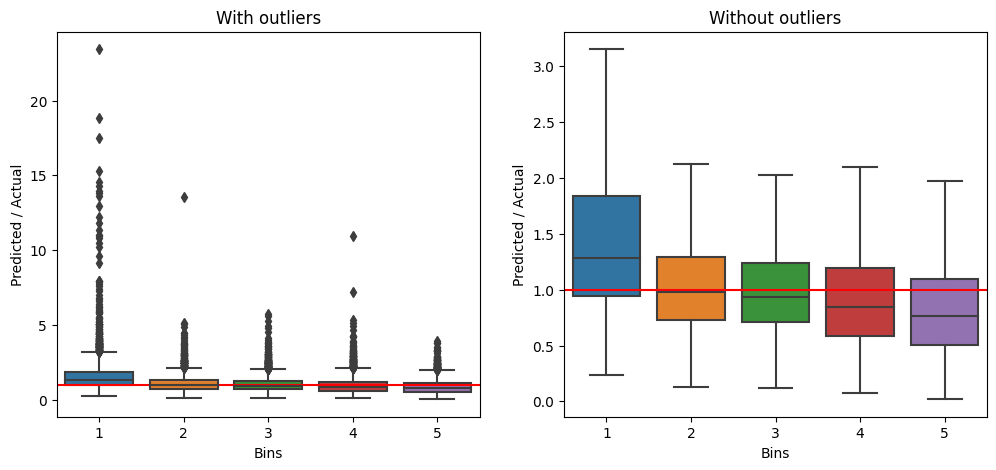

In [23]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

sns.boxplot(x='MarketValue_bins', y='frac', data=results, ax=axs[0])
axs[0].set_title('With outliers')
axs[0].set_xlabel('Bins')
axs[0].set_ylabel('Predicted / Actual')

sns.boxplot(x='MarketValue_bins', y='frac', data=results, ax=axs[1], showfliers=False)
axs[1].set_title('Without outliers')
axs[1].set_xlabel('Bins')
axs[1].set_ylabel('Predicted / Actual')

axs[0].axhline(y=1, color='r', linestyle='-')
axs[1].axhline(y=1, color='r', linestyle='-')

plt.show()

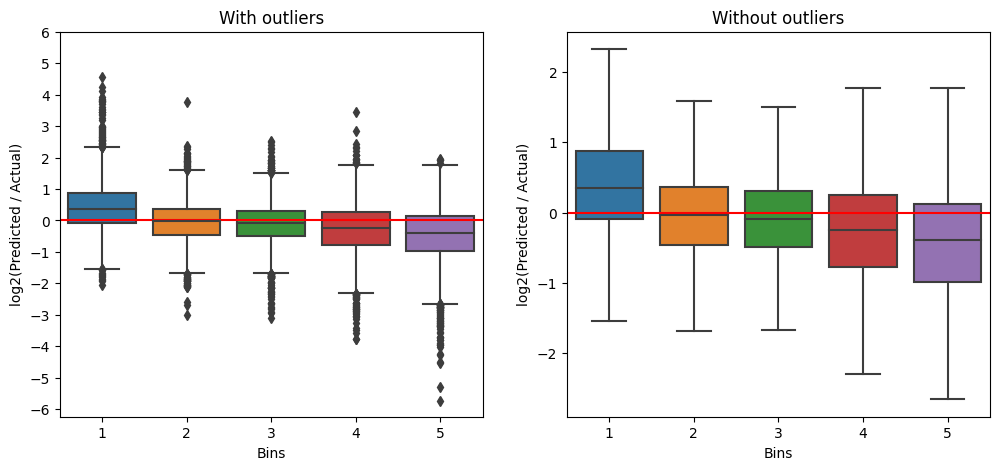

In [31]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

# sns.boxplot(x='MarketValue_bins', y='frac', data=results, ax=axs[0])
sns.boxplot(x='MarketValue_bins', y='log2', data=results, ax=axs[0])
axs[0].set_title('With outliers')
axs[0].set_xlabel('Bins')
axs[0].set_ylabel('log2(Predicted / Actual)')
axs[0].set_yticks(list(range(6,-7, -1)))

# sns.boxplot(x='MarketValue_bins', y='frac', data=results, ax=axs[1], showfliers=False)
sns.boxplot(x='MarketValue_bins', y='log2', data=results, ax=axs[1], showfliers=False)
axs[1].set_title('Without outliers')
axs[1].set_xlabel('Bins')
axs[1].set_ylabel('log2(Predicted / Actual)')


axs[0].axhline(y=0, color='r', linestyle='-')
axs[1].axhline(y=0, color='r', linestyle='-')


In [409]:
worst_10 = results.sort_values(by=['diff_abs'], ascending=False).head(10)
best_10 = results.sort_values(by=['diff_abs'], ascending=True).head(10)
# worst_10 = results.sort_values(by=['frac'], ascending=False).tail(10)
# best_10 = results.sort_values(by=['frac'], ascending=True).head(10)
worst_10

,Player_id,MarketValue,pred,age,diff,diff_abs,frac,frac_normalized,MarketValue_bins
9253,371998,100000000,193929473.0,21.0,93929473.0,93929473.0,1.939295,0.081983,5
7768,314353,80000000,149508830.0,23.0,69508830.0,69508830.0,1.868860,0.078977,5
11157,480692,65000000,5490798.0,24.0,-59509202.0,59509202.0,0.084474,0.002800,5
8968,357498,85000000,144173150.0,21.0,59173150.0,59173150.0,1.696155,0.071604,5
13430,683840,80000000,23385933.0,19.0,-56614067.0,56614067.0,0.292324,0.011673,5
8543,342229,160000000,214056196.0,23.0,54056196.0,54056196.0,1.337851,0.056307,5
12072,546543,55000000,4254081.0,22.0,-50745919.0,50745919.0,0.077347,0.002496,5
9936,401173,75000000,27878731.0,21.0,-47121269.0,47121269.0,0.371716,0.015062,5
10227,418560,150000000,103572366.0,21.0,-46427634.0,46427634.0,0.690482,0.028671,5
10968,466810,60000000,16044735.0,19.0,-43955265.0,43955265.0,0.267412,0.010610,5


In [410]:
best_10

,Player_id,MarketValue,pred,age,diff,diff_abs,frac,frac_normalized,MarketValue_bins
426,41369,150000,149998.0,35.0,-2.0,2.0,0.999987,0.041884,1
6883,274771,50000,49991.0,30.0,-9.0,9.0,0.999820,0.041877,1
13849,755327,200000,199991.0,18.0,-9.0,9.0,0.999955,0.041882,2
7380,291749,100000,100032.0,29.0,32.0,32.0,1.000320,0.041898,1
5833,235274,450000,450035.0,26.0,35.0,35.0,1.000078,0.041888,3
5420,216214,225000,224940.0,27.0,-60.0,60.0,0.999733,0.041873,2
13668,717198,200000,200073.0,17.0,73.0,73.0,1.000365,0.041900,2
2173,93818,200000,200078.0,29.0,78.0,78.0,1.000390,0.041901,2
168,28463,250000,250095.0,35.0,95.0,95.0,1.000380,0.041900,2
13729,727079,100000,100115.0,17.0,115.0,115.0,1.001150,0.041933,1


In [396]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test)
shap.initjs()

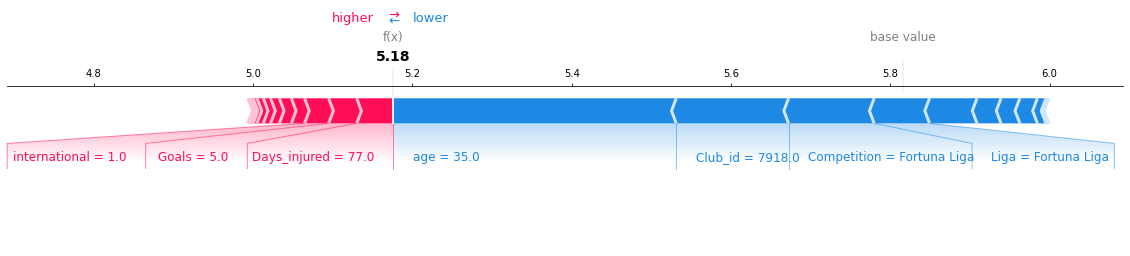

In [404]:
shap.force_plot(explainer.expected_value, shap_values[426, :], x_test.iloc[426], matplotlib=True)

In [131]:
# # save model
# model.save_model('catboost_model_test21.cbm')

In [132]:
# feature_importance = model.feature_importances_
# sorted_idx = np.argsort(feature_importance)
# fig = plt.figure(figsize=(12, 14))
# plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
# plt.yticks(range(len(sorted_idx)), np.array(train.drop(['MarketValue'], axis = 1).columns)[sorted_idx])
# plt.title('Feature Importance')

In [133]:
# pred = model.predict(x_test)
# pred = 10**(pred) - 1
# pred[pred < 0] = pred.mean()
# cat_rmsle = round(rmsle(y_test, pred), 2)
# print('Test RMSLE:', cat_rmsle)

In [134]:
# pred = model.predict(x_test)
# pred = 10**(pred) - 1
# # mean, std = scaler.mean_[columns_to_scale.index('MarketValue')], scaler.scale_[columns_to_scale.index('MarketValue')]
# # pred = pred * std + mean
# # y_test = y_test * std + mean

In [135]:
# pred[pred < 0] = pred.mean()
# cat_rmsle = round(rmsle(y_test, pred), 2)   
# print('Test RMSLE:', cat_rmsle) 

In [137]:
# shap.summary_plot(shap_values, x_test)

In [138]:
# shap.decision_plot(explainer.expected_value, shap_values[-2,:], x_test.iloc[-2,:])

In [139]:
# # # make a scorer
# # from sklearn.metrics import make_scorer
# # rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

# param_grid = {
#     'learning_rate': [0.01, 0.05, 0.1],
#     'depth': [3, 5, 7],
#     'l2_leaf_reg': [3, 5, 7],
#     'n_estimators': [1000, 2000]
# }
# # refit = True
# # n_jobs = -1

# test_size = 0.1
# n_splits = int((1//test_size)-1)
# print(f"n_splits: {n_splits}")

# tscv = TimeSeriesSplit(n_splits=n_splits)

# # model = CatBoostRegressor()

# # grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=rmsle_scorer, n_jobs=n_jobs, cv=tscv, refit=refit, verbose=10)

# # X = df.drop(['MarketValue'], axis=1)
# # y = df['MarketValue']
# # y = np.log10(y + 1)

In [140]:
# # plot the splits
# plt.figure(figsize=(12, 8))
# for i, (train_index, test_index) in enumerate(tscv.split(df)):
#     # Get the training and testing data
#     X_train, X_test = df.iloc[train_index], df.iloc[test_index]
#     # Plot the training and testing data with thicker lines
#     plt.plot(train_index, [i+1]*len(train_index), color='blue', linewidth=10)
#     plt.plot(test_index, [i+1]*len(test_index), color='orange', linewidth=11)

# # Add labels, grid and a legend
# plt.xlabel('Index')
# plt.ylabel('Market Value')
# plt.title('Rolling Window Cross-Validation')
# plt.grid(True)
# plt.legend(['Training', 'Testing'], loc="center right" ,fontsize='large')
# plt.show()

In [141]:
# grid_search.fit(X, y, cat_features=categorical_features)
# print(f'Model: {model} best params are: {grid_search.best_params_}')

In [142]:
# best_model = grid_search.best_estimator_
# # save the model
# best_model.save_model('catboost_model.cbm')

In [143]:
# # remove 2022
# df = df.query('Season < 2022')
# df.tail()

In [144]:
# scores = []
# X = df.drop(['MarketValue'], axis=1)
# y = df['MarketValue']

# for i, (train_index, test_index) in enumerate(tscv.split(df)):
#     # Get the training and testing data
#     X_train, y_train = X.iloc[train_index], y.iloc[train_index]
#     X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    
#     # scale the target
#     y_train = np.log10(y_train + 1)

#     # train and predict
#     model.fit(X_train, y_train, cat_features=categorical_features)
#     pred = model.predict(X_test)
#     pred = 10**(pred) - 1
#     pred[pred < 0] = pred.mean()
#     cat_rmsle = round(rmsle(y_test, pred), 2)
#     scores.append(cat_rmsle)

#     print(f"Fold {i+1} RMSLE: {cat_rmsle}")

# print('Mean Test RMSLE over all folds:', np.mean(scores))

# # plot the scores
# plt.figure(figsize=(12, 8))
# plt.plot(range(1, n_splits+1), scores, color='blue')
# plt.xlabel('Split')
# plt.ylabel('RMSLE')
# plt.title('Rolling Window Cross-Validation')
# plt.show()

KeyboardInterrupt: 

In [ ]:
# model.save_model('catboost_model_from_cv.cbm')

In [ ]:
# model = CatBoostRegressor()
# model.load_model('catboost_model_from_cv.cbm')